# Identifying Pneumonina using Convolutional Neural Networks

- Student Name: Kevin Spring
- Student pace: Flex
- Scheduled Project Review: December 12, 2022
- Instructor name: Morgan Jones
- Blog Post

# Summary


# Table of Contents

# Introduction

# Methodology

## Data

In [7]:
# Download the data.zip file and unpack it into test-train split using python_splitter
import os
from python_splitter import split_from_folder # https://github.com/bharatadk/python_splitter

# absolute path of unzipped data directory
PATH = os.path.join(os.path.abspath(os.getcwd()),'data/')
split_from_folder(PATH, train = 0.8, test=0.2)
#PATH

✅Checking SOURCE directory...
0.8 0 0.2
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [77]:
PATH

'/home/kevinspring/Documents/Flatiron/phase04/Pneumonia-detection-using-CNN/data/'

In [83]:
# Check class imbalance between pneumonia and normal x-ray
# folder path
dir_normal = os.path.join(PATH, 'NORMAL/')
dir_pneumonia = os.path.join(PATH, 'PNEUMONIA/')

# Iterate directory
def file_count(dir_path, class_name):
    count = 0
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    print(f'{class_name} file count: {count}')

file_count(dir_normal, 'Normal')
file_count(dir_pneumonia, 'Pneumonia')

Normal file count: 1583
Pneumonia file count: 4273


In [84]:
def file_count2(dir_path, class_name):
    count = 0
    for path in os.scandir(dir_path):
        if path.is_file():
            count += 1
    print(f'{class_name} file count: {count}')
    
file_count2(dir_normal, 'Normal')
file_count2(dir_pneumonia, 'Pneumonia')

Normal file count: 1583
Pneumonia file count: 4273


In [10]:
from tensorflow.python.client import device_lib
print(tf.__version__)
print(tf.config.list_physical_devices())
print(device_lib.list_local_devices())
import keras
print(keras.__version__)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18380095685153574076
xla_global_id: -1
]
2.10.0


In [12]:
import os, shutil

data_path = os.path.join(os.path.abspath(os.getcwd()),'Train_Test_Folder/')
#data_path = os.path.join(os.path.abspath(os.getcwd()),'archive\\chest_xray')
print(data_path)

train_dir = os.path.join(data_path, 'train/')
test_dir = os.path.join(data_path, 'test/')
#val_dir = os.path.join(data_path, 'val\\')

train_normal = os.path.join(train_dir, 'NORMAL/')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA/')

/home/kevinspring/Documents/Flatiron/phase04/Pneumonia-detection-using-CNN/Train_Test_Folder/


Image number: 1266
normal picture title:  NORMAL2-IM-1118-0001.jpeg
pneumonia picture title: person548_bacteria_2301.jpeg


Text(0.5, 1.0, 'Pneumonia')

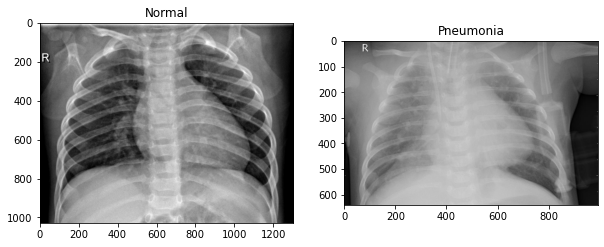

In [14]:
# Show a representative image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(f'Image number: {len(os.listdir(train_normal))}')
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
norm_img = os.listdir(train_normal)[rand_norm]
print('normal picture title: ', norm_img)
norm_img_address = train_normal+norm_img

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_pneumonia)))

pneu_img =  os.listdir(train_pneumonia)[rand_norm]
pneu_img_address = train_pneumonia+pneu_img
print('pneumonia picture title:', pneu_img)

# Load the image
norm_load = Image.open(norm_img_address)
pneu_load = Image.open(pneu_img_address)

# Show the picture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
ax1.set_title('Normal')

ax2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load, cmap='gray')
ax2.set_title('Pneumonia')

In [174]:
# Import data into tensorflow Dataset object
from tensorflow.keras.utils import image_dataset_from_directory

In [175]:
img_height = 64
img_width = 64
rgb = 3
grayscale = 1
batch_size = 32

train_ds, val_ds = image_dataset_from_directory(train_dir,
                                        color_mode='grayscale',
                                        label_mode='binary',
                                        validation_split=0.2,
                                        subset='both',
                                        seed=42,
                                        #shuffle=False,
                                        image_size=(img_height, img_width),
                                        batch_size = batch_size)

#A possible issue is that Keras validation_split uses the "last x percent" 
# of data as validation data without shuffling the data. 
# So if your data has a certain stratification, this stratification will 
# affect the validation set.

test_ds = image_dataset_from_directory(test_dir,
                                       shuffle=False,
                                       color_mode='grayscale',
                                       label_mode='binary',
                                       image_size=(img_height, img_width)
                                      )

print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for training -->', train_ds.cardinality())

Found 4684 files belonging to 2 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 2 classes.
Batches for testing --> tf.Tensor(37, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(30, shape=(), dtype=int64)
Batches for training --> tf.Tensor(118, shape=(), dtype=int64)


In [180]:
len(train_ds)

118

In [137]:
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['NORMAL', 'PNEUMONIA']
(32, 64, 64, 1)
(32, 1)


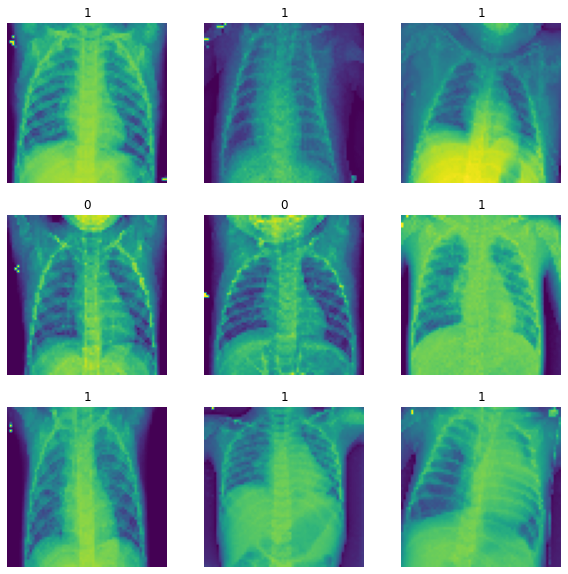

In [138]:
# Visualize the data

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')

In [139]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [140]:
# libraries for neural networks
#from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Rescaling
from keras.metrics import SpecificityAtSensitivity

In [141]:
def plot_fun(model, epochs):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'g-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'g-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#plot_fun(baseline_cnn_fit)
# Visualize training results
#plot_fun(cnn_model)

In [183]:
#import tensorflow.keras import layers

batch_size = 4
learning_rate = 0.0005

# Baseline model
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_baseline = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model_baseline.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model_baseline.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='baseline_model.keras',
        save_best_only=True,
        monitor='val_loss')
]

# Fit model
epochs=30
model_baseline_fit = model_baseline.fit(train_ds,
                                        steps_per_epoch=len(train_ds),
                                         epochs=epochs,
                                         validation_data = val_ds,
                                         batch_size=batch_size,
                                         callbacks=callbacks)

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_172 (Conv2D)         (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_134 (MaxPooli  (None, 31, 31, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_173 (Conv2D)         (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_174 (Conv2D)         (None, 12, 12, 128)       738

118/118 [==============================] - 17s 138ms/step - loss: 3.0619e-04 - accuracy: 1.0000 - recall_48: 1.0000 - specificity_at_sensitivity_48: 1.0000 - val_loss: 0.1204 - val_accuracy: 0.9669 - val_recall_48: 0.9754 - val_specificity_at_sensitivity_48: 0.9837
Epoch 26/30
118/118 [==============================] - 17s 140ms/step - loss: 2.8012e-04 - accuracy: 1.0000 - recall_48: 1.0000 - specificity_at_sensitivity_48: 1.0000 - val_loss: 0.1213 - val_accuracy: 0.9669 - val_recall_48: 0.9739 - val_specificity_at_sensitivity_48: 0.9837
Epoch 27/30
118/118 [==============================] - 17s 144ms/step - loss: 2.4315e-04 - accuracy: 1.0000 - recall_48: 1.0000 - specificity_at_sensitivity_48: 1.0000 - val_loss: 0.1227 - val_accuracy: 0.9690 - val_recall_48: 0.9768 - val_specificity_at_sensitivity_48: 0.9837
Epoch 28/30
118/118 [==============================] - 17s 143ms/step - loss: 2.1483e-04 - accuracy: 1.0000 - recall_48: 1.0000 - specificity_at_sensitivity_48: 1.0000 - val_loss

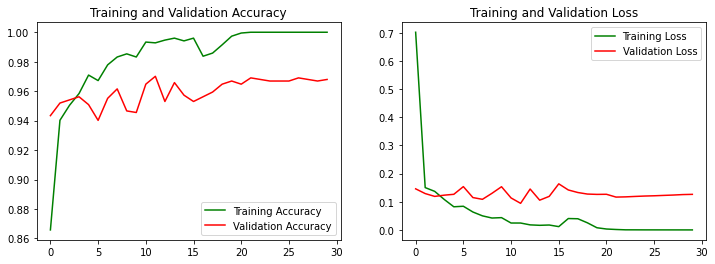

In [184]:
plot_fun(model_baseline_fit, epochs)

In [127]:
# Discussion
# 

In [187]:
# Model 2
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model2.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model2.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='model2.keras',
        save_best_only=True,
        monitor='val_loss')
]

# Fit model
epochs=10
model2_fit = model_baseline.fit(train_ds,
                                steps_per_epoch=len(train_ds),
                                 epochs=epochs,
                                 validation_data = val_ds,
                                 batch_size=batch_size,
                                 callbacks=callbacks)

Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_41 (Rescaling)    (None, 64, 64, 1)         0         
                                                                 
 conv2d_178 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_179 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_140 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                    

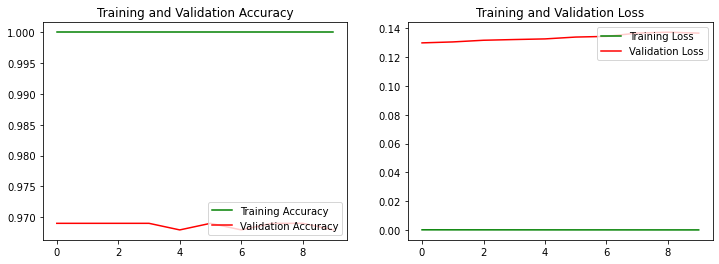

In [188]:
plot_fun(model2_fit, epochs)

In [ ]:
# Model 3
# Include a dropout
from keras.layers import Dropout

learning_rate = 0.00001

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model3.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model3.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='model3.keras',
        save_best_only=True,
        monitor='val_loss')
]


# Fit model
epochs=10
model3_fit = model_baseline.fit(train_ds,
                                steps_per_epoch=len(train_ds),
                                 epochs=epochs,
                                 validation_data = val_ds,
                                 batch_size=batch_size,
                                 callbacks=callbacks)

Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_42 (Rescaling)    (None, 64, 64, 1)         0         
                                                                 
 conv2d_181 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_142 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_182 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_143 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                    

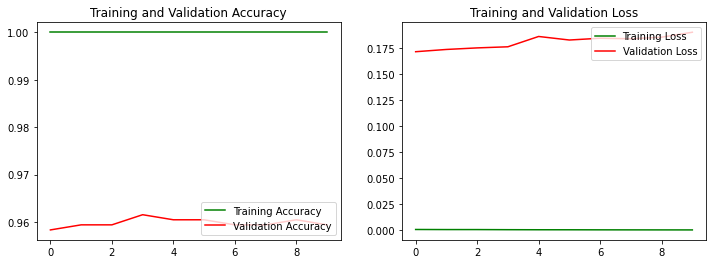

In [132]:
plot_fun(model3_fit, epochs)

In [ ]:
# Model 3 discussion
# Even with dropout the data is immediatly at 100% training accuracy but at 95% validation accuracy

In [135]:
# Model 4: Data augmentation
from keras import layers

data_augmentation = Sequential(
        [
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ])

from keras.layers import Dropout

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Dropout(0.1)(x)
x = Rescaling(1./255)(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model4.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model4.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='model4.keras',
        save_best_only=True,
        monitor='val_loss')
]

# Fit model
epochs=20
model4_fit = model_baseline.fit(train_ds,
                                steps_per_epoch=len(train_ds),
                                 epochs=epochs,
                                 validation_data = val_ds,
                                 batch_size=batch_size)

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 sequential_8 (Sequential)   (None, 64, 64, 1)         0         
                                                                 
 dropout_39 (Dropout)        (None, 64, 64, 1)         0         
                                                                 
 rescaling_31 (Rescaling)    (None, 64, 64, 1)         0         
                                                                 
 conv2d_112 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                          

KeyboardInterrupt: 

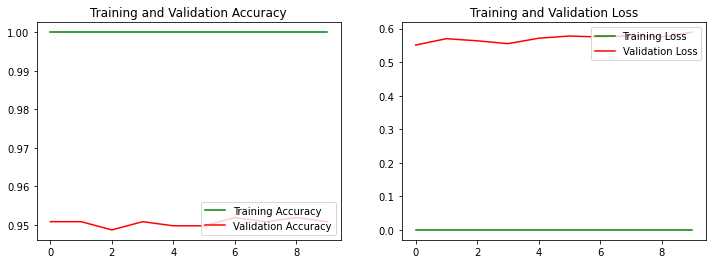

In [104]:
plot_fun(model4_fit, epochs)

In [ ]:
# Discussion 5 epochs

In [ ]:
model_aug.summary()

In [72]:
# Model with transfer learning
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(img_height, img_width, rgb))

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [75]:
# Model 5
# With a pretrained model

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Conv2D(3,(3,3), padding='same')(x)
x = keras.applications.vgg19.preprocess_input(x)
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs, outputs)

# Compile
model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction_with_data_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

model5_fit = model5.fit(train_ds,
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size)

Epoch 1/10
118/118 [==============================] - 181s 2s/step - loss: 2.4997 - accuracy: 0.6790 - val_loss: 0.5785 - val_accuracy: 0.7372
Epoch 2/10
118/118 [==============================] - 184s 2s/step - loss: 0.6033 - accuracy: 0.7241 - val_loss: 0.5695 - val_accuracy: 0.7372
Epoch 3/10
118/118 [==============================] - 172s 1s/step - loss: 0.5925 - accuracy: 0.7271 - val_loss: 0.6114 - val_accuracy: 0.7372
Epoch 4/10
118/118 [==============================] - 171s 1s/step - loss: 0.5878 - accuracy: 0.7279 - val_loss: 0.5811 - val_accuracy: 0.7372
Epoch 5/10
118/118 [==============================] - 168s 1s/step - loss: 0.5871 - accuracy: 0.7279 - val_loss: 0.5764 - val_accuracy: 0.7372
Epoch 6/10
118/118 [==============================] - 169s 1s/step - loss: 0.5868 - accuracy: 0.7279 - val_loss: 0.5764 - val_accuracy: 0.7372
Epoch 7/10
118/118 [==============================] - 173s 1s/step - loss: 0.5865 - accuracy: 0.7279 - val_loss: 0.5768 - val_accuracy: 0.7372

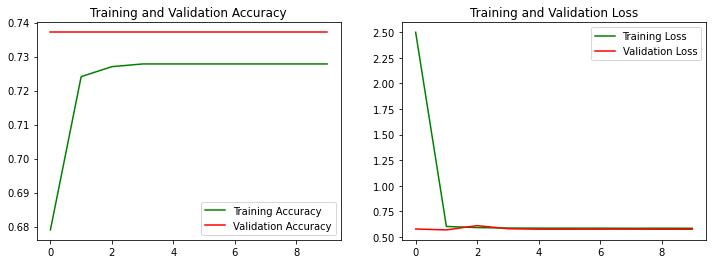

In [76]:
plot_fun(model5_fit, epochs)

In [105]:
# Analyze models on test data

test_loss, test_accuracy, test_recall, test_specificity = model4.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy:.3f}')

37/37 [==============================] - 1s 25ms/step - loss: 0.7066 - accuracy: 0.2705 - recall_21: 0.0000e+00 - specificity_at_sensitivity_21: 0.1451
Test accuracy: 0.270


In [86]:
model3.evaluate(test_ds)

37/37 [==============================] - 1s 23ms/step - loss: 0.6996 - accuracy: 0.2705 - recall_12: 0.0012 - specificity_at_sensitivity_12: 0.0158


[0.6996099352836609,
 0.2704778015613556,
 0.0011695906287059188,
 0.015772869810461998]